# Lernen auf mathematischen Daten 
# -- Daten erzeugen und Vorhersagen erzeugen

Mathematische Daten sind:
* nicht gemessen, sondern erzeugt
* exakt (keine Messfehler)
* Ergebnis klar definierten Regeln

Beispiele:
* Graphen mit Nebenbedingungen
* Zahlenfolgen, Matrizen, Polynome
* Konfigurationen mit Extremaleigenschaften
* Lösungen eines Suchproblems

Experimental Mathematics
1. Problem definieren
2. Beispiele erzeugen
3. Muster beobachten
4. Vermutungen formulieren
5. Beweise entwickeln

### Beispiel
### Was ist die maximale Anzahl von Kanten eines Graphen mit $n$ Knoten, der kein Dreieck enthält?

**Definition**
> Ein (einfacher) Graph $G=(V,E)$ besteht aus 
> * einer endlichen Menge von Knoten $V$
> * einer Menge von Kanten $E\subset \{\{i,j\}|i,j\in V, i\neq j\}$
>
> Wir betrachten nur:
> * ungerichtete Graphen
> * ohne Schleifen
> * ohne Mehrfachkanten

**Definition**
> Ein Dreieck ist einvollständiger Teilgraph auf drei Knoten.
>
> Formal: Es existiern $i,j,k\in V$ mit $\{i,j\}, \{j,k\}, \{i,k\}\in E$

Datenstruktur-Voraussetzung dieses gesamten Programmcodes

Alle hier verwendeten Funktionen setzen voraus, dass der Graph durch eine Adjazenzmatrix (adjacency matrix) dargestellt wird:

* $A$ ist eine $n \times n$-Matrix
* $A[i,j]=1$ bedeutet, dass zwischen den Knoten $i$ und $j$ eine Kante existiert
* Ungerichteter Graph $\Rightarrow A$ ist symmetrisch $(A[i,j]=A[j,i])$
* Einfacher Graph $\Rightarrow$ keine Schleifen $(A[i,i]=0)$

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

#### 0) Utility functions

In [2]:
def count_edges(A: np.ndarray) -> int:
    """Number of undirected edges."""
    return int(A.sum() // 2) # A[i,j]= A[j,i]= 1

Klassische Bedeutung der Matrixmultiplikation
* $(A^2)[i,j]$ gibt die Anzahl der Walks der Länge 2 von $i$ nach $j$ an
* $(A^3)[i,j]$ gibt die Anzahl der Walks der Länge 3 von $i$ nach $j$ an

Insbesondere:
* $(A^3)[i,i]$ Ein Dreieck $i-j-k-i$ ist genau ein solcher geschlossener Walk der Länge 3

Betrachte ein Dreieck $\{i, j, k\} $ in einem ungerichteten einfachen Graphen:
* Es gibt 3 Möglichkeiten, den Startknoten zu wählen
* Für einen festen Startknoten gibt es 2 Laufrichtungen

Damit wird dasselbe Dreieck in $tr(A^3)$ insgesamt $3 \times 2 = 6$ Mal gezählt.

$\#$ Dreiecke $=\dfrac{tr(A^3)}{6}$

In [3]:
def count_triangles(A: np.ndarray) -> int:
    """Triangles = trace(A^3)/6 for undirected simple graphs."""
    return int(np.trace(A @ A @ A) // 6)

In [4]:
def is_triangle_free(A: np.ndarray) -> bool:
    return count_triangles(A) == 0

Dies beschreibt die Erzeugung eines Erdős–Rényi-Zufallsgraphen $G(n,p)$:

Für jedes Paar verschiedener Knoten $(i,j)$ wird unabhängig mit Wahrscheinlichkeit $p$ eine Kante hinzugefügt.

In [5]:
def random_graph(n: int, p: float, seed=None) -> np.ndarray:
    """Erdos-Renyi G(n,p) as adjacency matrix."""
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    A = np.zeros((n, n), dtype=np.int8)
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                A[i, j] = 1
                A[j, i] = 1
    return A

In [6]:
def shuffled_edges(n: int):
    edges = [(i, j) for i in range(n) for j in range(i+1, n)] # {(i,j):0<=i<j<=n-1}
    random.shuffle(edges)
    return edges

#### 1) Data generation method 1:
#### Greedy from empty (triangle-free)

In [7]:
def greedy_triangle_free(n: int, seed=None) -> np.ndarray:
    """
    Start from empty graph; try to add random edges, but only if it stays triangle-free.
    Efficient triangle check via neighbor sets.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    A = np.zeros((n, n), dtype=np.int8)
    neighbors = [set() for _ in range(n)]

    for (u, v) in shuffled_edges(n):
        # Adding (u,v) creates a triangle iff u and v have a common neighbor
        if neighbors[u].intersection(neighbors[v]):
            continue
        A[u, v] = 1
        A[v, u] = 1
        neighbors[u].add(v)
        neighbors[v].add(u)

    return A

* neighbors[u] ist eine Menge
* gespeichert sind alle Knoten, die mit $u$ verbunden sind (die Nachbarn von $u$)

Das entspricht in der Graphentheorie: $N(u)=\{ w|(u,w)\in E\}$

Wenn man die Kante $(u,v)$ hinzufügt, entsteht genau dann ein Dreieck, wenn es einen Knoten $w$ gibt, so dass:
* $u$ bereits mit $w$ verbunden ist (also $w\in N(u)$)
* $v$ bereits mit $w$ verbunden ist (also $w\in N(v)$)

Das heißt äquivalent: $N(u)\cap N(v)\neq \emptyset$

Ist der Schnitt nicht leer, dann entsteht es das Dreieck mit den Knoten $u,v,w$

#### 2) Local search "down-and-up":
   #### Down: destroy triangles by removing "bad" edges
   #### Up: add edges while staying triangle-free

In [8]:
def edge_triangle_participation(A: np.ndarray) -> np.ndarray:
    """
    For each existing edge (i,j), count how many triangles contain that edge.
    """
    n = A.shape[0]
    T = np.zeros((n, n), dtype=np.int32)
    for i in range(n):
        for j in range(i+1, n):
            if A[i, j] == 1:
                common = np.where((A[i] == 1) & (A[j] == 1))[0]
                c = int(len(common))
                T[i, j] = c
                T[j, i] = c
    return T

In [9]:
def down_phase_remove_triangles(A: np.ndarray, max_steps: int = 10_000) -> np.ndarray:
    """
    Repeatedly remove an edge that participates in many triangles until triangle-free.
    """
    B = A.copy()
    steps = 0
    while count_triangles(B) > 0 and steps < max_steps:
        T = edge_triangle_participation(B)
        max_t = T.max()
        # choose among edges with maximum triangle participation
        candidates = np.argwhere((B == 1) & (T == max_t))
        candidates = [(int(i), int(j)) for i, j in candidates if i < j]
        if not candidates:
            break
        u, v = random.choice(candidates)
        B[u, v] = 0
        B[v, u] = 0
        steps += 1
    return B

In [10]:
def up_phase_add_edges_triangle_free(A: np.ndarray) -> np.ndarray:
    """
    From a triangle-free graph, try to add random edges without creating triangles.
    """
    B = A.copy()
    n = B.shape[0]
    neighbors = [set(np.where(B[i] == 1)[0].tolist()) for i in range(n)]

    for (u, v) in shuffled_edges(n):
        if B[u, v] == 1:
            continue
        if neighbors[u].intersection(neighbors[v]):
            continue
        B[u, v] = 1
        B[v, u] = 1
        neighbors[u].add(v)
        neighbors[v].add(u)
    return B

In [ ]:
#neighbors = [set(np.where(B[i] == 1)[0].tolist()) for i in range(n)]
#   ||
#neighbors=[]
#for i in range(n):
#    idx=np.where(B[i]==1)[0] #Bestimme, an welchen Stellen in der i-ten Zeile der Wert 1 vorkommt.
#    lst=idx.tolist()
#    neighbors.append(set(lst))

In [11]:
def down_and_up(A0: np.ndarray) -> np.ndarray:
    """
    Full local search: remove triangles, then maximize edges under triangle-free constraint.
    """
    B = down_phase_remove_triangles(A0)
    B = up_phase_add_edges_triangle_free(B)
    return B

#### 3) Quick visualization helpers (matrix heatmap)

In [12]:
def show_adj_heatmap(A: np.ndarray, title: str = ""):
    plt.figure()
    plt.imshow(A, interpolation="nearest")
    plt.title(title)
    plt.xlabel("vertex")
    plt.ylabel("vertex")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [ ]:
# Task A.1
# Erzeugen Sie 300 dreiecksfreie Graphen mit n=20  Knoten unter Verwendung der Funktion greedy_triangle_free.
# Stellen Sie anschließend ein Histogramm der Anzahl der Kanten dar.

In [13]:
def task_A1_histogram(n=20, N=300, seed=0):
    random.seed(seed); np.random.seed(seed)
    edges = []
    for _ in range(N):
        A = greedy_triangle_free(n)
        edges.append(count_edges(A))

    plt.figure()
    plt.hist(edges, bins=30)
    plt.title(f"Aufgabe A.1: edge distribution (n={n}, N={N})")
    plt.xlabel("#edges")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    print("A.1 summary:", "mean =", np.mean(edges), "max =", np.max(edges))
    return edges

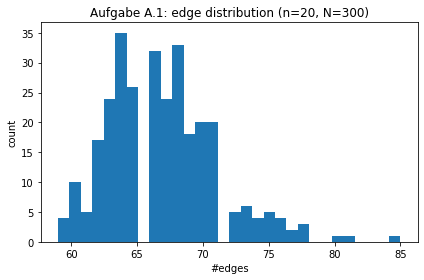

A.1 summary: mean = 66.9 max = 85


In [14]:
if __name__ == "__main__":
    # A: distribution from greedy construction
    task_A1_histogram(n=20, N=300, seed=1)

In [ ]:
# Task B.1:
# Vergleich verschiedener Startpunkte für die lokale Suche:
#   (i) leerer Graph
#   (ii) zufälliger Graph G(n,p)
# Vergleichen Sie die Anzahl der Kanten nach der Anwendung von down_and_up.

In [15]:
def task_B1_compare_start(n=20, p=0.5, seed=0):
    random.seed(seed); np.random.seed(seed)

    # Case (i): start from empty
    A0 = np.zeros((n, n), dtype=np.int8)
    A1 = down_and_up(A0)
    e_empty = count_edges(A1)

    # Case (ii): start from random graph
    A0_random = random_graph(n, p)
    A2 = down_and_up(A0_random)
    e_random = count_edges(A2)

    print(f"B.1 results (n={n}):")
    print("  start=empty  -> edges =", e_empty, "| triangles =", count_triangles(A1))
    print("  start=random -> edges =", e_random, "| triangles =", count_triangles(A2))

    # Optional: show adjacency matrices
    show_adj_heatmap(A1, title=f"B.1: result from empty (edges={e_empty})")
    show_adj_heatmap(A2, title=f"B.1: result from random (edges={e_random})")

B.1 results (n=20):
  start=empty  -> edges = 64 | triangles = 0
  start=random -> edges = 77 | triangles = 0


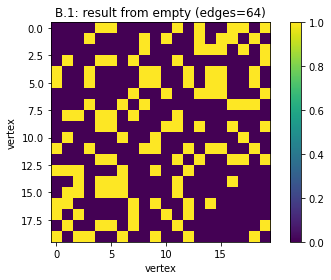

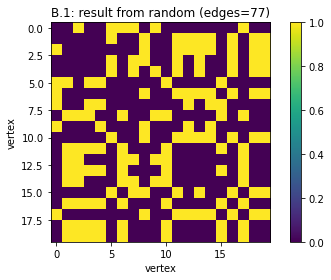

In [16]:
if __name__ == "__main__":
    # B: effect of start distribution
    task_B1_compare_start(n=20, p=0.5, seed=2)

## Struktur erkennen: bipartit

**Definition**
> Ein Graph $G=(V,E)$ heißt bipartit, wenn es eine Zerlegung $V=V_{1}\cup V_{2}$ gibt, sodass $E\subset V_{1}\times V_{2}$

In [17]:
def C0_bipartite_graph(n1, n2, p, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n = n1 + n2
    A = np.zeros((n, n), dtype=np.int8)
    for i in range(n1):
        for j in range(n1, n):
            if np.random.rand() < p:
                A[i, j] = 1
                A[j, i] = 1
    return A

C0 bipartite graph: edges = 85


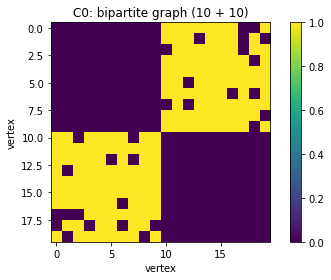

In [18]:
A_bip = C0_bipartite_graph(10, 10, p=0.8, seed=0)
edges = count_edges(A_bip)
print(f"C0 bipartite graph: edges = {edges}")
show_adj_heatmap(A_bip, title="C0: bipartite graph (10 + 10)")

C0 bipartite graph: edges = 100


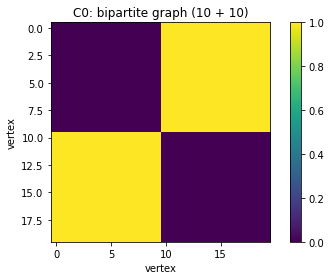

In [20]:
A_bip = C0_bipartite_graph(10, 10, p=1, seed=0)
edges = count_edges(A_bip)
print(f"C0 bipartite graph: edges = {edges}")
show_adj_heatmap(A_bip, title="C0: bipartite graph (10 + 10)")

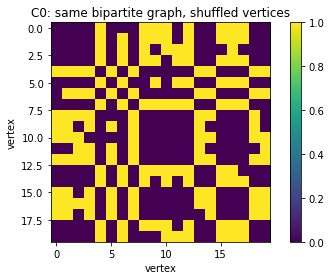

In [19]:
# Same graph, but vertices shuffled
perm = np.random.permutation(20)
A_shuffled = A_bip[perm][:, perm]

show_adj_heatmap(A_shuffled, title="C0: same bipartite graph, shuffled vertices")

In [ ]:
# Task C.1:
# Wählen Sie aus der erzeugten Menge von Graphen denjenigen
# mit der größten Anzahl von Kanten aus
# und betrachten Sie dessen Adjazenzmatrix als Heatmap.

In [20]:
def task_C1_show_best(n=20, N=200, seed=0):
    random.seed(seed); np.random.seed(seed)

    best_A = None
    best_e = -1
    for _ in range(N):
        A = greedy_triangle_free(n)
        e = count_edges(A)
        if e > best_e:
            best_e = e
            best_A = A

    print(f"C.1 best edges among {N} samples:", best_e, "| triangles:", count_triangles(best_A))
    show_adj_heatmap(best_A, title=f"C.1: best sample (edges={best_e})")
    
    return best_A

C.1 best edges among 200 samples: 84 | triangles: 0


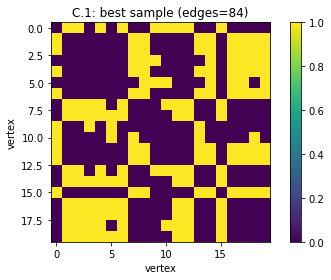

In [21]:
if __name__ == "__main__":
    # C: "best sample" visualization for structure guessing
    task_C1_show_best(n=20, N=200, seed=3)

In [22]:
def task_C1_show_best(n=20, N=200, seed=0):
    random.seed(seed); np.random.seed(seed)

    best_A = None
    best_e = -1
    for _ in range(N):
        A = down_and_up(random_graph(n, p=0.3))
        e = count_edges(A)
        if e > best_e:
            best_e = e
            best_A = A

    print(f"C.1 best edges among {N} samples:", best_e, "| triangles:", count_triangles(best_A))
    show_adj_heatmap(best_A, title=f"C.1: best sample (edges={best_e})")
    
    return best_A

C.1 best edges among 200 samples: 91 | triangles: 0


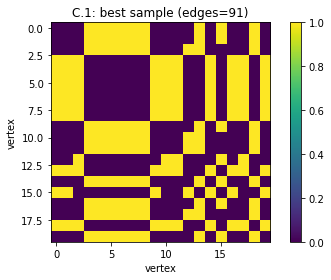

In [23]:
if __name__ == "__main__":
    # C: "best sample" visualization for structure guessing
    task_C1_show_best(n=20, N=200, seed=4)

Vorhersage hier bedeutet:
* Vorhersage guter Startpunkte
* Vorhersage vielversprechender Strukturen

#### Klassisches Resultat: Mantel- Theorem
**Satz** (Mantel, 1907)
> Ein dreiecksfreier Graph auf $n$ Knoten hat höchstens $\left\lfloor\dfrac{n^2}{4}\right\rfloor$ Kanten.

Gleichheit genau dann, wenn:  Der Graph bipartit und möglichst ausgeglichen ist.

### Kurzer Blick auf andere Beispiele
Die gleiche Grundidee taucht inzwischen in vielen Bereichen der Mathematik auf, zum Beispiele
* in der Zahlentheorie (z.B. experimentelle Untersuchungen zu Konstanten)
* in der Geometrie (z.B. Generierung extremaler Polytopen)
* in der Kombinatorik (z.B. Suche nach extremalen Graphen)

Daten werden erzeugt, nicht gemessen-
und Lernen bedeutet Struktur erkennen, nicht Vorhersagen im Zeitlauf.

**Literatur**
1. Charton, François, et al. "Patternboost: Constructions in mathematics with a little help from ai." arXiv preprint arXiv:2411.00566 (2024).
2. Fevola, Claudia, and Christiane Görgen. "The mathematical research-data repository MathRepo." arXiv preprint arXiv:2202.04022 (2022).
3. Davies, Alex, et al. "Advancing mathematics by guiding human intuition with AI." Nature 600.7887 (2021): 70-74.
4. Williamson, Geordie. "Is deep learning a useful tool for the pure mathematician?." arXiv preprint arXiv:2304.12602 (2023).
5. Davies, Alex, et al. "Drums of high width." Proceedings of the London Mathematical Society 130.3 (2025): e70031.